In [11]:
import numpy as np
import torch
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [12]:
# Rearranges matrix into a column vector

def im2col(image, block_size = (1,1), skip=1):

    rows, cols = image.shape
    vert_blocks = rows - block_size[0] + 1

    output_vectors = np.zeros((block_size[0] * block_size[1], cols * rows))
    itr = 0
    for row in range(rows):
        for col in range(cols):
            output_vectors[:, itr] = image[row: row + block_size[0], col: col + 1].ravel()
            itr += 1

    return output_vectors[:, ::skip]

# Performs function of Fig2 (left), creates data matrix X, and outputs the covariance of this matrix. 
# Requires input of ONE CHANNEL, not RGB

def one_channel_to_cov(image, filter_size):
    x, y = filter_size
    H, W = image.shape
    X = [0]*(x*y)
    for i in range(x):
        for j in range(y):
            
            X[y*i + j] = im2col(np.array(image[i:W+i-x+1, j:H+j-y+1]), )


    X = np.squeeze(np.asarray(X)).T

    u = np.mean(X)
    N = X.shape[0]

    X = (X-u).T @ X
    Cov = X / N
    
    return Cov

# This function is provided in the Network Deconvolution paper.
# Numerical approximation of inverse sqrt. Used to invertsqrt the Cov matrix to get Deconv matrix D.

def isqrt_newton_schulz_autograd(A, numIters):
    dim = A.shape[0]
    normA=A.norm()
    Y = A.div(normA)
    I = torch.eye(dim,dtype=A.dtype,device=A.device)
    Z = torch.eye(dim,dtype=A.dtype,device=A.device)

    for i in range(numIters):
        T = 0.5*(3.0*I - Z@Y)
        Y = Y@T
        Z = T@Z
    #A_sqrt = Y*torch.sqrt(normA)
    A_isqrt = Z / torch.sqrt(normA)
    print(A_isqrt)
    return A_isqrt

# plot kernel in 3D
def plot_3D(ker):
    # Set up grid and test data
    nx, ny = 15, 15
    x = range(nx)
    y = range(ny)

    hf = plt.figure()
    ha = hf.add_subplot(111, projection='3d')

    X, Y = np.meshgrid(x, y)  
    ha.plot_surface(X, Y, np.reshape(ker, (15,15)))

    plt.show()

################
# Executes above functions to take ONE CHANNEL input, return kernel (as a vector)

def channel_to_kernel(image, k):
  # Data Matrix X
    cov = one_channel_to_cov(image, (k, k))

    # Deconv matrix D is equal to inverse sqrt of cov matrix. 
    D = isqrt_newton_schulz_autograd(torch.Tensor(cov), 10)

    
    # Extract kernel from Deconv matrix
    ker = torch.diagonal(D)

    return ker


In [13]:
#SET FILTER SIZE
k = 15

In [14]:
# im_name must be string ending in .jpeg

def load_image(im_name):
    #load image
    image = Image.open(im_name)
    # convert image to numpy array
    data = asarray(image)

    data_square = data
    #Resize to square, reduce size for computational efficiency
    data_square = np.resize(data_square, (224,224,3))

    return data_square

In [15]:
# Random ImageNet images downloaded and named im1-im10 in local folder

data   = load_image('ImageNet/im1.JPEG')
data2  = load_image('ImageNet/im2.JPEG')
data3  = load_image('ImageNet/im3.JPEG')
data4  = load_image('ImageNet/im4.JPEG')
data5  = load_image('ImageNet/im5.JPEG')
data6  = load_image('ImageNet/im6.JPEG')
data7  = load_image('ImageNet/im7.JPEG')
data8  = load_image('ImageNet/im8.JPEG')
data9  = load_image('ImageNet/im9.JPEG')
data10 = load_image('ImageNet/im10.JPEG')

In [16]:
RGB = ['Red', 'Green', 'Blue']

for i in range(3):
    
    ker = None
    ker = torch.zeros((15,15))

    print(RGB[i])

    ker+=torch.Tensor(channel_to_kernel(data[:,:,i],    k)).reshape(15,15)
    ker+=torch.Tensor(channel_to_kernel(data2[:,:,i],   k)).reshape(15,15)
    ker+=torch.Tensor(channel_to_kernel(data3[:,:,i],   k)).reshape(15,15)
    ker+=torch.Tensor(channel_to_kernel(data4[:,:,i],   k)).reshape(15,15)
    ker+=torch.Tensor(channel_to_kernel(data5[:,:,i],   k)).reshape(15,15)
    ker+=torch.Tensor(channel_to_kernel(data6[:,:,i],   k)).reshape(15,15)
    ker+=torch.Tensor(channel_to_kernel(data7[:,:,i],   k)).reshape(15,15)
    ker+=torch.Tensor(channel_to_kernel(data8[:,:,i],   k)).reshape(15,15)
    ker+=torch.Tensor(channel_to_kernel(data9[:,:,i],   k)).reshape(15,15)
    ker+=torch.Tensor(channel_to_kernel(data10[:,:,i],  k)).reshape(15,15)

    if i == 0:
        ker0 = ker
    if i == 1:
        ker1 = ker
    if i == 0:
        ker2 = ker
        

Red
tensor([[ 4.9170e-02, -1.7764e-02, -6.3144e-03,  ...,  5.1057e-05,
         -5.7055e-05, -1.3576e-04],
        [-1.7759e-02,  5.6623e-02, -1.5127e-02,  ..., -7.6242e-05,
          4.0627e-05, -3.9856e-05],
        [-6.3077e-03, -1.5125e-02,  5.7452e-02,  ..., -1.0889e-04,
         -7.5297e-05,  5.1725e-05],
        ...,
        [ 1.0170e-04, -3.8428e-05, -7.5825e-05,  ...,  5.6423e-02,
         -1.5269e-02, -5.9389e-03],
        [ 4.3213e-06,  8.5404e-05, -3.6390e-05,  ..., -1.5266e-02,
          5.5665e-02, -1.7864e-02],
        [-3.8867e-05,  2.7817e-05,  1.0889e-04,  ..., -5.9329e-03,
         -1.7862e-02,  4.7886e-02]])
tensor([[ 3.9475e-02, -1.4994e-02, -2.7861e-03,  ...,  1.5377e-04,
          1.0937e-04,  2.2037e-04],
        [-1.4994e-02,  4.6525e-02, -1.3740e-02,  ..., -1.0090e-05,
          1.3739e-04,  9.6456e-05],
        [-2.7843e-03, -1.3740e-02,  4.6660e-02,  ..., -8.9454e-05,
         -4.6511e-06,  1.7009e-04],
        ...,
        [ 1.3202e-04, -2.5498e-05, -1.0339

tensor([[ 8.0570e-02, -3.9011e-02, -1.3942e-02,  ...,  5.6785e-05,
          1.7574e-04,  3.6246e-05],
        [-3.8991e-02,  1.0336e-01, -3.1081e-02,  ...,  3.7059e-05,
         -1.3054e-05,  1.8937e-04],
        [-1.3931e-02, -3.1081e-02,  1.0582e-01,  ...,  1.7002e-04,
          2.3463e-05,  6.0286e-05],
        ...,
        [ 9.0145e-05,  5.6302e-05,  1.8778e-04,  ...,  1.0618e-01,
         -3.1380e-02, -1.3960e-02],
        [ 2.3362e-04,  1.4547e-05,  4.6663e-05,  ..., -3.1376e-02,
          1.0366e-01, -3.9359e-02],
        [ 1.8858e-04,  2.5035e-04,  1.0450e-04,  ..., -1.3939e-02,
         -3.9337e-02,  8.0320e-02]])
tensor([[ 0.4591, -0.0536, -0.0169,  ...,  0.0017,  0.0020,  0.0027],
        [-0.0534,  0.4652, -0.0519,  ...,  0.0015,  0.0015,  0.0022],
        [-0.0167, -0.0518,  0.4653,  ...,  0.0009,  0.0015,  0.0018],
        ...,
        [-0.0037, -0.0033, -0.0037,  ...,  0.4599, -0.0566, -0.0217],
        [-0.0034, -0.0034, -0.0032,  ..., -0.0566,  0.4596, -0.0588],
     

tensor([[ 9.7268e-02, -3.3630e-02, -1.6075e-03,  ...,  2.8817e-04,
          1.7981e-04, -8.9303e-05],
        [-3.3633e-02,  1.1327e-01, -3.3651e-02,  ...,  2.2106e-04,
          1.9117e-04,  2.2741e-04],
        [-1.6105e-03, -3.3652e-02,  1.1333e-01,  ...,  5.6528e-04,
          1.8413e-04,  2.5883e-04],
        ...,
        [ 2.0661e-04,  1.6278e-04,  5.1084e-04,  ...,  1.0553e-01,
         -3.1248e-02, -1.5744e-03],
        [ 9.5777e-05,  1.3084e-04,  1.2771e-04,  ..., -3.1249e-02,
          1.0549e-01, -3.1173e-02],
        [-2.1933e-04,  1.4343e-04,  1.8068e-04,  ..., -1.5772e-03,
         -3.1175e-02,  9.0680e-02]])
tensor([[ 3.0507e-02, -1.5273e-02,  4.2496e-03,  ..., -2.2385e-04,
          5.0852e-05, -8.1097e-05],
        [-1.5272e-02,  4.1517e-02, -1.9270e-02,  ...,  1.2579e-04,
         -2.7248e-04,  5.6761e-05],
        [ 4.2494e-03, -1.9270e-02,  4.3312e-02,  ..., -1.0800e-04,
          1.3019e-04, -2.2884e-04],
        ...,
        [-2.2299e-04,  1.2587e-04, -1.0748e-04

Red Channel Deconv Kernel


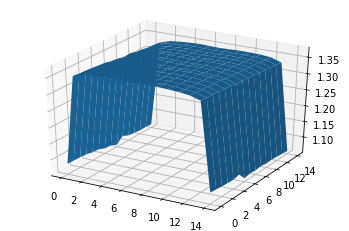

Green Channel Deconv Kernel


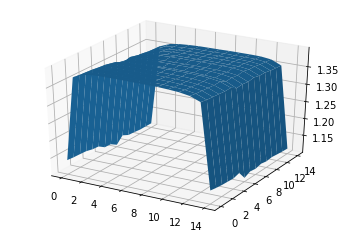

Blue Channel Deconv Kernel


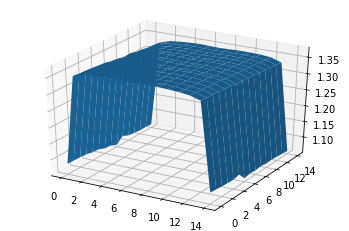

In [17]:
print('Red Channel Deconv Kernel')
plot_3D(np.array(ker0))
print('Green Channel Deconv Kernel')
plot_3D(np.array(ker1))
print('Blue Channel Deconv Kernel')
plot_3D(np.array(ker2))